# Analyze A/B Test Results

###### By Karim El-Dweky

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that I get some practice working with the difficulties of these. 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [125]:
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [126]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [127]:
# Number of rows in the dataset
df.shape[0]

294478

**Number of rows in the dataset are** 294478

c. The number of unique users in the dataset.

In [128]:
# Number of unique users in the dataset
df.user_id.nunique()

290584

**Number of unique users in the dataset are** 290584

d. The proportion of users converted.

In [129]:
# The proportion of users converted
df.converted.mean()

0.11965919355605512

**The proportion of users converted is** 0.11966

e. The number of times the `new_page` and `treatment` don't line up.

In [130]:
# The number of times the new_page and treatment don't line up
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

**The number of times the new_page and treatment don't line up are** 3893

f. Do any of the rows have missing values?

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**There are no missing values.**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [132]:
# Creating new dataset that meets the specifications by removing the rows which not aligned.
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) != False]

In [133]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [134]:
# Number of unique users in **df2**
df2.user_id.nunique()

290584

**The Number of unique users in *df2* are** 290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [135]:
# The one repeated **user_id** in **df2**
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

**The one repeated *user_id* in *df2* is** 773192

c. What is the row information for the repeat **user_id**? 

In [136]:
# The row information for the repeat **user_id**
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [137]:
# Removing the one row with a duplicated **user_id** and keeping the datafram as **df2**
df2.drop_duplicates(subset = 'user_id', inplace = True)

<ipython-input-137-03de6dbe38bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop_duplicates(subset = 'user_id', inplace = True)


In [138]:
# Test
df2.user_id.duplicated().sum()

0

In [139]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [140]:
# The probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959708724499628

**The probability of an individual converting regardless of the page they receive is** 0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [141]:
# The probability of an individual was in the **control** group and they **converted**.
df2[(df2['group'] == 'control')].converted.mean()

0.1203863045004612

**The probability of an individual was in the *control* group and they *converted* is** 0.1204

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [142]:
# The probability of an individual was in the **treatment** group and they **converted**.
df2[(df2['group'] == 'treatment')].converted.mean()

0.11880806551510564

**The probability of an individual was in the *treatment* group and they *converted* is** 0.1188

d. What is the probability that an individual received the new page?

In [143]:
# The probability that an individual received the **new page**
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

**The probability that an individual received the *new page* is** 0.5001

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer**: 

- There is no sufficient evidence to say that the new treatment page leads to more conversions (the conversion probability for each page is 'almost' the same). Moreover, the probability of conversion of the control group is even slightly higher than the probability of conversion of the treatment group (conv_prob_control > conv_prob_treatment). The number of events leading to old and new pages is well ballanced (new_page_prob) for each page type (there is no bias existing potentially disturbing existence of the evidence).

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer:**
- Null hypothesis: the conversion rate of the new_page is less or the same than the conversion rate of the old_page.

**$H_{0}$ : $p_{new}$ <= $p_{old}$   ( $p_{new}$ - $p_{old}$ <= 0 )**

- Alternative hypothesis: the conversion rate of the new_page is greater than the conversion rate of the old_page.

**$H_{1}$ : $p_{new}$ > $p_{old}$   ( $p_{new}$ - $p_{old}$ > 0 )**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

**The Null hypothesis states there is not difference between the conversion rates of old and new page.**

a. What is the **convert rate** for $p_{new}$ under the null? 

In [144]:
# The convert rate for  𝑝𝑛𝑒𝑤  under the null.
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**The convert rate for $p_{new}$ under the null is** 0.1196

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [145]:
# The convert rate for  𝑝𝑜𝑙𝑑  under the null
p_old = df2['converted'].mean()
p_old

0.11959708724499628

**The convert rate for $p_{old}$ under the null is** 0.1196

c. What is $n_{new}$?

In [146]:
# The number of users landed on new_page 𝑛𝑛𝑒𝑤
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_new

145310

**The number of users landed on new_page $n_{new}$ is** 145310

d. What is $n_{old}$?

In [147]:
# The number of users landed on old_page 𝑛old
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

**The number of users landed on old_page $n_{old}$ is** 145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [148]:
# Simulation of 𝑛𝑛𝑒𝑤  transactions with a convert rate of  𝑝𝑛𝑒𝑤  under the null 
# And storing 𝑛𝑛𝑒𝑤  1's and 0's in new_page_converted.
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])

# Calculating new_page_converted Mean
new_page_converted.mean()

0.11855343747849426

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [149]:
# Simulation of 𝑛𝑜𝑙𝑑  transactions with a convert rate of  𝑝𝑜𝑙𝑑  under the null 
# And storing 𝑛𝑜𝑙𝑑  1's and 0's in new_page_converted.
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])

# Calculating old_page_converted Mean
old_page_converted.mean()

0.11933312223797789

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [150]:
# Calculating (𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑) for my simulated values from part (e) and (f)
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0007796847594836315

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [151]:
# running the simulation for 10000 times
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

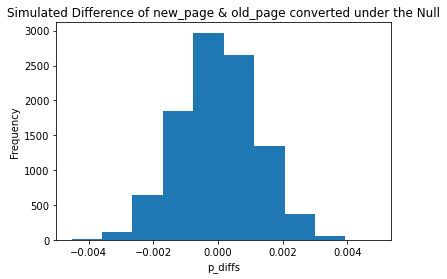

In [152]:
# convert p_diffs to numpy array
p_diffs = np.array(p_diffs)

# plot sampling distribution
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference of new_page & old_page converted under the Null');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [153]:
# dividing df2 into df2_control & df2_treatment
df2_control = df2[df2.group == 'control']
df2_treatment = df2[df2.group == 'treatment']

# displaying observed difference
obs_diff = df2_treatment.converted.mean() - df2_control.converted.mean()
obs_diff

-0.0015782389853555567

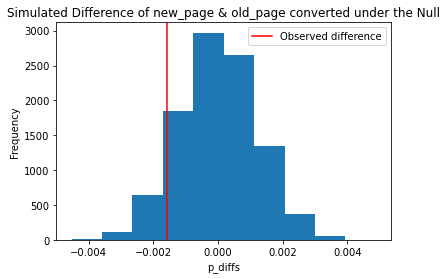

In [154]:
# plot line for observed statistic above sampling distribution
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r', label="Observed difference")
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference of new_page & old_page converted under the Null');
plt.legend()
plt.show()

In [155]:
#calculating the proportion of p_diffs greater than the observe difference
(p_diffs > obs_diff).mean()

0.9073

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

- 0.9063 is the proportion of the p_diffs that are greater than the actual difference observed in *ab_data.csv*. In scientific studies this value is also called *p-value*. This value means that we cannot reject the null hypothesis and that we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [156]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_new = df2[df2.landing_page == 'new_page'].shape[0]

In [157]:
print('convert_old = {}\nconvert_new = {}\nn_old = {}\nn_new = {}'.format(convert_old, convert_new, n_old, n_new))

convert_old = 17489
convert_new = 17264
n_old = 145274
n_new = 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [158]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],
                                              [n_old, n_new],
                                              value=None,
                                              alternative='smaller',
                                              prop_var=False)
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [159]:
norm.cdf(z_score) # this tells us how significant our z-score is

0.9050583127590245

In [160]:
norm.ppf(1-(0.05/2)) # this tells us our critical value at 95% confidence interval

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**

- The z-score of 1.31 is less than critical value at 95% confidence interval, 1.96. Also, The p-value is far greater than alpha (alpha = 0.05)
- So, We fail to reject the null hypothesis; the old page converted more users than the new page.
- A z-score is the number of standard deviations from the mean a data point is (obs_diff). The z-score and p-value (p-value = 0.9051) computed in the previous question agree with the findings in parts j and k (p-value == 0.9063).

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [161]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [162]:
### Create the necessary dummy variables

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [163]:
### Fit Your Linear Model And Obtain the Results

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.